 As point clouds são dados que podem ser extraídos de formas diferentes:
 um par de câmeras (geometria estéreo), sensor LiDAR (Light Detection And
 Ranging), sensores de profundidade e etc. Nessa tarefa, você receberá um
 conjunto de 30 scans extraídos de um LiDAR, estes dados são parte do KITTI
 DATASET. Utilize as point clouds de cada scan para estimar a trajetória final do
 veículo, de forma que essa trajetória se inicie no primeiro scan. Para estimar a
 trajetória percorrida pelo carro você deve usar o algoritmo Iterative
 Closest-Points (ICP). Contudo, você não pode utilizar bibliotecas de terceiros
 para isso. Você deve fazer sua própria implementação do algoritmo ICP. Em
 seu código, você deve mostrar que sua implementação está correta. Além disso,
 estamos anexando a ground-truth que é um arquivo .npy, que pode ser aberto
 com a biblioteca NumPy. Ao carregá-lo, você terá um array de tamanho (30, 4, 4).
 Cada linha, primeiro índice, representa uma matriz de transformação em
 coordenadas homogêneas para cada uma das 30 posições do carro

# bibliotecas

In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 16.3 MB/s eta 0:00:00


In [12]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import os
import trimesh
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d import Axes3D

# extrair os dados

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CODIGO

In [4]:
# Caminho para a pasta "all_points" no Google Drive
path_to_points = "/content/drive/MyDrive/all_points"

point_clouds = []

# Carregar os arquivos .obj da pasta
for file_name in sorted(os.listdir(path_to_points)):
    if file_name.endswith(".obj"):
        mesh = trimesh.load(os.path.join(path_to_points, file_name))
        point_clouds.append(mesh.vertices)

print(f"{len(point_clouds)} nuvens de pontos carregadas.")

30 nuvens de pontos carregadas.


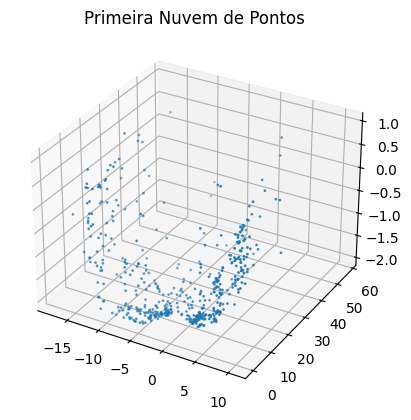

Número de nuvens de pontos: 30
Formato da primeira nuvem de pontos: (500, 3)


In [34]:
# Visualizar a primeira nuvem de pontos
first_cloud = np.array(point_clouds[0])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_cloud[:, 0], first_cloud[:, 1], first_cloud[:, 2], s=1)
ax.set_title('Primeira Nuvem de Pontos')
plt.show()
print(f"Número de nuvens de pontos: {len(point_clouds)}")
print(f"Formato da primeira nuvem de pontos: {point_clouds[0].shape}")


# codigo ICP

In [36]:
# Função para reduzir o número de pontos em uma nuvem
def downsample_point_cloud(points, num_samples):
    if len(points) > num_samples:
        indices = np.random.choice(len(points), num_samples, replace=False)
        return points[indices]
    return points

# # Carregar e reduzir as nuvens de pontos
# point_clouds = [
#     downsample_point_cloud(trimesh.load(os.path.join(path_to_points, file_name)).vertices)
#     for file_name in sorted(os.listdir(path_to_points))
#     if file_name.endswith(".obj")
# ]

print(f"{len(point_clouds)} nuvens de pontos carregadas e reduzidas.")

# Função para calcular o centróide
def calculate_centroid(points):
    return np.mean(points, axis=0)

# Função para calcular a transformação rígida com SVD
def compute_rigid_transform(A, B):
    # Calcula os centróides
    centroid_A = calculate_centroid(A)
    centroid_B = calculate_centroid(B)

    # Centraliza os pontos
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Calcula a matriz de covariância
    H = A_centered.T @ B_centered

    # Decomposição SVD
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Garante que a matriz de rotação seja válida
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Calcula o vetor de translação
    t = centroid_B - R @ centroid_A

    return R, t

# Função ICP
def icp(source, target, max_iterations=200, tolerance=1e-8):
    previous_error = float('inf')
    transformation = np.eye(4)
    source_transformed = source.copy()

    for i in range(max_iterations):
        # Encontrar correspondências usando KD-Tree
        tree = cKDTree(target)
        distances, indices = tree.query(source_transformed)
        closest_points = target[indices]

        # Calcular transformação rígida
        R, t = compute_rigid_transform(source_transformed, closest_points)

        # Aplicar transformação
        source_transformed = (R @ source_transformed.T).T + t

        # Calcular erro médio
        current_error = np.mean(distances)
        if abs(previous_error - current_error) < tolerance:
            print(f"Convergência atingida em {i+1} iterações.")
            break

        previous_error = current_error
        transformation[:3, :3] = R @ transformation[:3, :3]
        transformation[:3, 3] += t

    return transformation


30 nuvens de pontos carregadas e reduzidas.


# CHAMDA DA FUNÇÃO

In [41]:
# Inicializar a trajetória
trajectory = [np.array([0, 0, 0])]
current_cloud = point_clouds[0]

# Aplicar ICP e reduzir progressivamente as nuvens de pontos
for i in range(1, len(point_clouds)):
    print(f"Alinhando nuvem {i-1} com {i}...")
    source_reduced = downsample_point_cloud(current_cloud, 500)
    target_reduced = downsample_point_cloud(point_clouds[i], 500)

    transformation = icp(source_reduced, target_reduced, max_iterations=2000, tolerance=1e-8)

    # Atualizar posição e nuvem corrente
    next_position = transformation[:3, 3] + trajectory[-1]
    trajectory.append(next_position)
    current_cloud = (transformation[:3, :3] @ current_cloud.T).T + transformation[:3, 3]

trajectory = np.array(trajectory)

Alinhando nuvem 0 com 1...
Convergência atingida em 19 iterações.
Alinhando nuvem 1 com 2...
Convergência atingida em 15 iterações.
Alinhando nuvem 2 com 3...
Convergência atingida em 9 iterações.
Alinhando nuvem 3 com 4...
Convergência atingida em 18 iterações.
Alinhando nuvem 4 com 5...
Convergência atingida em 21 iterações.
Alinhando nuvem 5 com 6...
Convergência atingida em 37 iterações.
Alinhando nuvem 6 com 7...
Convergência atingida em 15 iterações.
Alinhando nuvem 7 com 8...
Convergência atingida em 12 iterações.
Alinhando nuvem 8 com 9...
Convergência atingida em 26 iterações.
Alinhando nuvem 9 com 10...
Convergência atingida em 28 iterações.
Alinhando nuvem 10 com 11...
Convergência atingida em 18 iterações.
Alinhando nuvem 11 com 12...
Convergência atingida em 16 iterações.
Alinhando nuvem 12 com 13...
Convergência atingida em 13 iterações.
Alinhando nuvem 13 com 14...
Convergência atingida em 23 iterações.
Alinhando nuvem 14 com 15...
Convergência atingida em 11 iterações.


# visualização

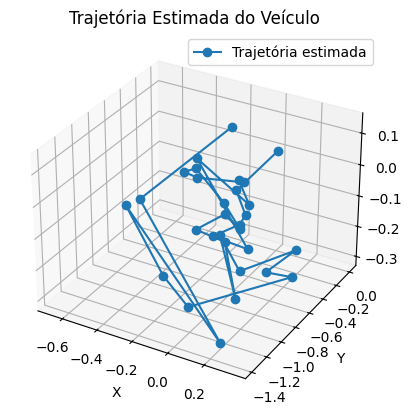

In [42]:
# Plotar a trajetória 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Trajetória estimada', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Trajetória Estimada do Veículo')
plt.show()


# comparação com gorund-truth

In [43]:
# Carregar o arquivo ground-truth
ground_truth = np.load('/content/drive/MyDrive/all_points/ground_truth.npy')

# Extrair a trajetória da Ground Truth
ground_truth_trajectory = np.array([matrix[:3, 3] for matrix in ground_truth])

# Calcular o erro entre a trajetória estimada e a Ground Truth
errors = np.linalg.norm(trajectory - ground_truth_trajectory, axis=1)

# Exibir os erros para cada ponto
for i, error in enumerate(errors):
    print(f"Ponto {i}: Erro = {error:.4f}")

# Erro médio
mean_error = np.mean(errors)
print(f"\nErro médio da trajetória: {mean_error:.4f}")

Ponto 0: Erro = 0.0000
Ponto 1: Erro = 1.0306
Ponto 2: Erro = 1.9333
Ponto 3: Erro = 2.7487
Ponto 4: Erro = 3.6358
Ponto 5: Erro = 4.4651
Ponto 6: Erro = 5.1786
Ponto 7: Erro = 6.1094
Ponto 8: Erro = 6.9065
Ponto 9: Erro = 7.7068
Ponto 10: Erro = 8.4915
Ponto 11: Erro = 9.3667
Ponto 12: Erro = 10.2669
Ponto 13: Erro = 11.1751
Ponto 14: Erro = 12.1381
Ponto 15: Erro = 12.9356
Ponto 16: Erro = 13.8560
Ponto 17: Erro = 14.7824
Ponto 18: Erro = 15.7622
Ponto 19: Erro = 16.5268
Ponto 20: Erro = 17.4891
Ponto 21: Erro = 18.4354
Ponto 22: Erro = 19.4404
Ponto 23: Erro = 20.2597
Ponto 24: Erro = 21.2216
Ponto 25: Erro = 22.0635
Ponto 26: Erro = 22.9624
Ponto 27: Erro = 24.0803
Ponto 28: Erro = 24.7848
Ponto 29: Erro = 25.4959

Erro médio da trajetória: 12.7083


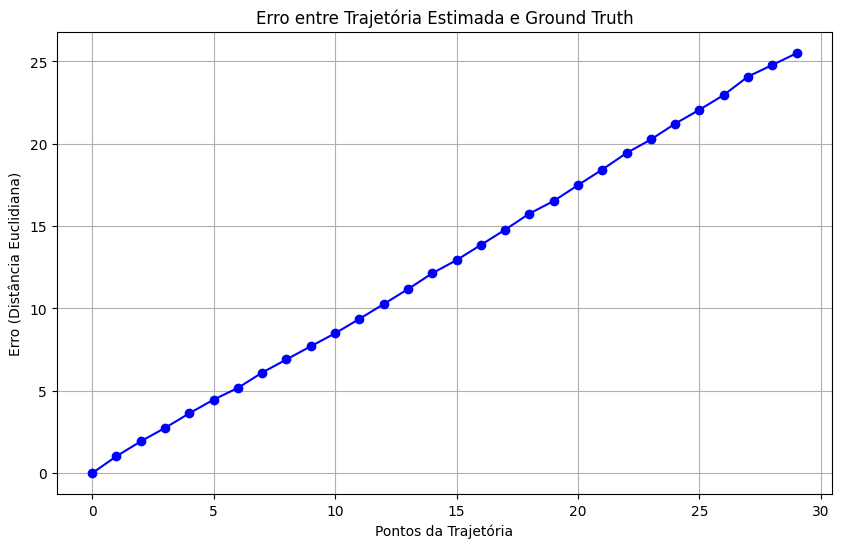

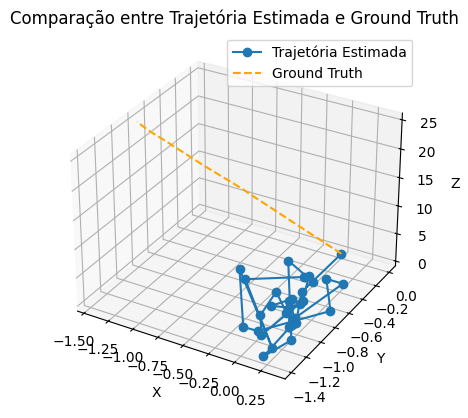

In [44]:
# Plotar os erros
plt.figure(figsize=(10, 6))
plt.plot(range(len(errors)), errors, marker='o', linestyle='-', color='b')
plt.title('Erro entre Trajetória Estimada e Ground Truth')
plt.xlabel('Pontos da Trajetória')
plt.ylabel('Erro (Distância Euclidiana)')
plt.grid()
plt.show()

# Plotar a comparação entre trajetórias novamente
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Trajetória Estimada', marker='o')
ax.plot(ground_truth_trajectory[:, 0], ground_truth_trajectory[:, 1], ground_truth_trajectory[:, 2],
        label='Ground Truth', linestyle='--', color='orange')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Comparação entre Trajetória Estimada e Ground Truth')
plt.show()
